## Multiscale HiTS

### created by Yuying Liu, 05/07/2020

This script is a template for benchmarking multiscale HiTS against single time-scale neural network time-steppers. We find multiscale HiTS can provide the most accurate forecasts with good efficiency. 

With the help of this script, one can reproduce:
- Figure 5
- Table 5

In [2]:
import os
import sys
import time
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [48]:
# adjustables
time_list = np.linspace(0, 8*np.pi, 500)
dt = time_list[1] - time_list[0]                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'toy1'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'

In [4]:
# path
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
# ks = list(range(11))
ks = list(range(6))
step_sizes = [2**k for k in ks]
print(step_sizes)

[1, 2, 4, 8, 16, 32]


### load data & models

In [5]:
# load validation set and test set
# val_data = np.load(os.path.join(data_dir, 'val_noise0.0.npy'))
# test_data = np.load(os.path.join(data_dir, 'test_noise0.0.npy'))

data = np.load(os.path.join(data_dir, "train_data.npy"))#inputs_2x2.npy"))#'train_noise{}.npy'.format(noise)))

data_full = np.load(os.path.join(data_dir, "total_data.npy"))
# print(np.load("../../data/Hyperbolic/train_noise0.0.npy").shape)
# data = np.expand_dims(data, 1)
train_data = data[:75]
val_data = data[75:90]
test_data = data[90:]

train_data_full = data_full[:75]
val_data_full = data_full[75:90]
test_data_full = data_full[90:]

In [76]:
# load models
models = list()
for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    models.append(torch.load(os.path.join(model_dir, 'model_D{}_noise0.0_0.pt'.format(step_size)), map_location='cpu'))
    
# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load model_D1.pt
load model_D2.pt
load model_D4.pt
load model_D8.pt
load model_D16.pt
load model_D32.pt


### benchmarks

In [78]:
# shared info
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\multiscale_HiTS\src\ResNet.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


(array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04, 1.e+06, 1.e+08, 1.e+10,
        1.e+12, 1.e+14]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

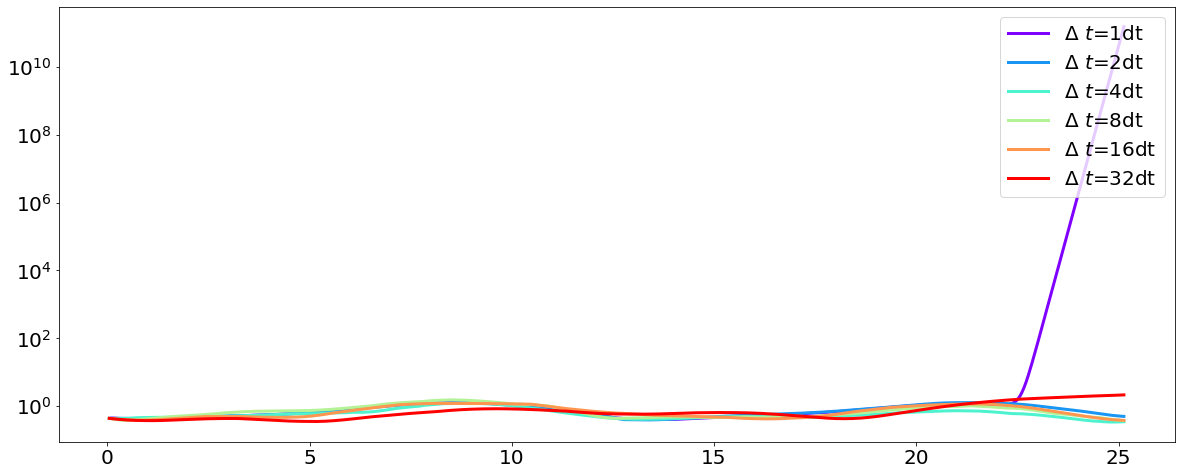

In [79]:
# # uniscale time-stepping with NN
preds_mse = list()
times = list()

n_test, n_timesteps, dimension = test_data.shape
n_per_dim = int(np.sqrt(dimension))
_,_,dimension_full = test_data_full.shape
n_per_dim_full = int(np.sqrt(dimension_full))


y_preds_full = np.zeros((n_test, n_timesteps-1, dimension_full)).reshape(n_test, n_timesteps-1, n_per_dim_full, n_per_dim_full)
split_point = int(n_per_dim_full/n_per_dim)
for model in tqdm(models):
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps).reshape(n_test, n_timesteps-1, n_per_dim, n_per_dim)
    for i in range(n_per_dim):
        for j in range(n_per_dim):
            for n in range(n_test):
                for t in range(n_timesteps-1):
                    y_preds_full[n, t,i*split_point:i+1*split_point, j*split_point:j+1*split_point] = y_preds[n,t,i, j]
    end = time.time()
    times.append(end - start)
    truth = torch.tensor(test_data_full[:, 1:, :]).float().reshape(n_test, n_timesteps-1, n_per_dim_full, n_per_dim_full)#.detach().numpy()

    mse = criterion(truth, torch.tensor(y_preds_full).float()).flatten(start_dim=2)
    preds_mse.append(mse.mean(-1))
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
for k in range(len(ks)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(time_list[1:], mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.ylim([1e-4, 10])
    

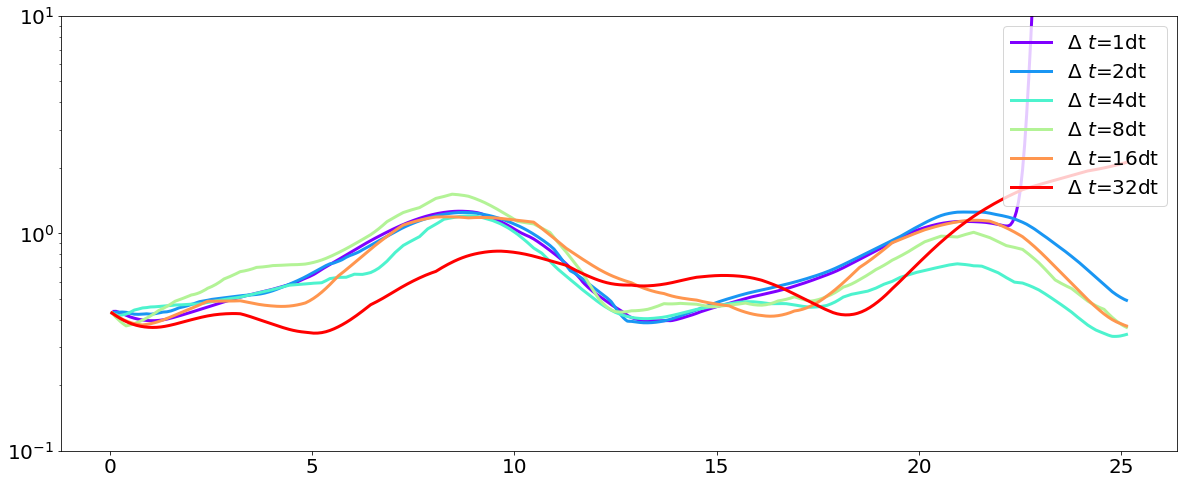

In [60]:
# # visualize forecasting error at each time step    
# fig = plt.figure(figsize=(20, 8))
# colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
# # print(colors)
# for k in range(len(ks)):
#     err = preds_mse[k]
#     mean = err.mean(0).detach().numpy()
#     rgb = next(colors)
# #     print("time_list shape = ", len(time_list))
# #     print("mean shape = ", mean.shape)
#     plt.semilogy(time_list[1:], mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
# plt.legend(fontsize=20, loc='upper right')
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

# plt.ylim([1e-1, 10])

# plt.show()


In [81]:
# cross validation (model selections) 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5
# choose the largest time step
for i in tqdm(range(len(models))):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[:len(models)-i])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

        # choose the smallest time step
for i in tqdm(range(end_idx)):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[i:end_idx])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
        
# start_idx = 0
print('use models {} - {}.'.format(start_idx, end_idx))
models = models[start_idx:end_idx]


use models 0 - 2.


In [ ]:
# multiscale time-stepping with NN
# start = time.time()
# end = time.time()
# multiscale_time = end - start
# multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)

# # uniscale time-stepping with NN
# preds_mse = list()
# times = list()

# n_test, n_timesteps, dimension = test_data.shape
# n_per_dim = int(np.sqrt(dimension))
# _,_,dimension_full = test_data_full.shape
# n_per_dim_full = int(np.sqrt(dimension_full))


y_preds_full = np.zeros((n_test, n_timesteps-1, dimension_full)).reshape(n_test, n_timesteps-1, n_per_dim_full, n_per_dim_full)
split_point = int(n_per_dim_full/n_per_dim)
# for model in tqdm(models):
start = time.time()
y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models).reshape(n_test, n_timesteps-1, n_per_dim, n_per_dim)
#     y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps).reshape(n_test, n_timesteps-1, n_per_dim, n_per_dim)
for i in range(n_per_dim):
    for j in range(n_per_dim):
        print("i = ", i, ": j = ", j)
        for n in range(n_test):
            for t in range(n_timesteps-1):
#                     print("y_preds_full shape = ", y_preds_full.shape)
#                     print("y_preds shape = ", y_preds.shape)
                y_preds_full[n, t,i*split_point:i+1*split_point, j*split_point:j+1*split_point] = y_preds[n,t,i, j]
end = time.time()
times.append(end - start)
truth = torch.tensor(test_data_full[:, 1:, :]).float().reshape(n_test, n_timesteps-1, n_per_dim_full, n_per_dim_full)#.detach().numpy()

multiscale_preds_mse = criterion(truth, torch.tensor(y_preds_full).float()).flatten(start_dim=2)
#     preds_mse.append(mse.mean(-1))
#     multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)

    
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
multiscale_err = multiscale_preds_mse.mean(0).detach().numpy()
for k in range(len(ks)):#len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(time_list[1:], mean, linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.semilogy(time_list[1:], multiscale_err, linestyle='-', color='k', linewidth=6, label='multiscale')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)

plt.ylim([1e-4, 10])


i =  0 : j =  0
i =  0 : j =  1
i =  1 : j =  0
i =  1 : j =  1


(0.0001, 10)

In [73]:
print(len(preds_mse))

2


In [ ]:
model16 = (torch.load(os.path.join(model_dir, 'model_D{}_noise0.0_0.pt'.format(16)), map_location='cpu'))
print(model)

plt.figure()

n_steps_this = 30
for j in range(10):
    current = torch.tensor(test_data[j, 0, :]).float()
    predicted = np.zeros((n_steps_this, 4))
    for i in range(n_steps_this):
        predicted[i] = current.detach().numpy()
        current = model16(current)


    print(predicted.shape)

    t = np.linspace(0, 8*np.pi, 500)
    print(t.shape)

    truth = test_data[0, ::16, 0]

    plt.semilogy(t[:n_steps_this]*16, np.sqrt((predicted[:,0] - truth[:n_steps_this])**2))
# plt.plot(t, test_data[0, :, 0])
plt.show()

In [ ]:
import matplotlib.animation as animation

def animate(snapshots, file_name = "animation.gif"):


    fps = 30
    nSeconds = len(snapshots)/fps
    # snapshots = [ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]

    # a=output
    # snapshots = output
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = snapshots[0,:,:,:][0].T
    im = plt.imshow(a, interpolation='none', aspect='auto', vmin=-2.5, vmax=2.5)
    plt.colorbar()
    
    print("Animating, may take a little while...")

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(snapshots[i,:,:,:,][0].T)
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = int(nSeconds * fps),
                                   interval = 1000 / fps, # in ms
                                   )
    writergif = animation.PillowWriter(fps=30)
    anim.save(file_name, writer=writergif)#, fps=30)


    print('Done! gif saved to ', file_name)

    # plt.show()  # Not required, it seems!

In [ ]:
y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)

y_preds = y_preds.unsqueeze(2)
print(y_preds.shape)
animate(y_preds[0].detach().numpy().reshape(499,1,2,2), file_name = "animation.gif")

print(y_preds.shape)

In [ ]:
# integration of a sampled test trial 
# (you need to change the code here accordingly as state variables are different for different systems)
idx = 15
t = np.linspace(0, (n_steps-1)*dt, n_steps)
fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(t, test_data[idx, 0:n_steps, 0], 'r-', linewidth=10, label='x')
ax0.plot(t, test_data[idx, 0:n_steps, 1], 'b-', linewidth=10, label='y')
# ax0.plot(t, test_data[idx, 0:n_steps, 2], 'g-', linewidth=10, label='z')
ax0.plot(t, y_preds[idx, 0:n_steps, 0].detach().numpy(), 'k--', linewidth=10, label='learned')
ax0.plot(t, y_preds[idx, 0:n_steps, 1].detach().numpy(), 'k--', linewidth=10)
# ax0.plot(t, y_preds[idx, 0:n_steps, 2].detach().numpy(), 'k--', linewidth=10)
ax0.legend(fontsize=50, loc='upper right')
ax0.tick_params(axis='both', which='major', labelsize=60)

In [ ]:
# computation time
for i in range(len(times)):
    print('single scaled model (Dt={}): computing time {}s'.format(step_sizes[i]*dt, times[i]))
print('ensembled multiscale model: computing time {}s'.format(multiscale_time))

In [ ]:
# i = 0
# #for the d models
# preds_mse_each = list()
# for j in range(4):
#     if j == 0:
#         model = models[i]
#     elif j == 1:
#         model = models_b[i]
#     elif j == 2:
#         model = models_c[i]
#     else:
#         model = models_d[i]
#     y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
#     preds_mse_each.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))

colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
# for j in range(4):
err = preds_mse_each[j]
mean = err.mean(0).detach().numpy()
rgb = next(colors)
plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    
# preds_mse3 = list()
# times3 = list()
# for model in tqdm(models_d):
#     start = time.time()
#     y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
#     end = time.time()
#     times3.append(end - start)
#     preds_mse3.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
    

In [ ]:
print(len(preds_mse_each))
print(len(preds_mse_each[0]))